# Example where block/coordinate descent doesn't reach the same solution

They should converge to the same solution, but in practice they don't, and this notebook illustrates such an example using a $10 \times 10$ matrix. 

In [7]:
# load packages needed for this tutorial
using Revise
using Knockoffs
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
using CSV, DataFrames
using Plots
gr(fmt=:png);

function get_sigma(option::Int, p::Int)
    # note: groups are defined empirically within each simuation
    datadir = "/Users/biona001/Benjamin_Folder/research/4th_project_PRS/group_knockoff_test_data"
    if option == 1
        ρ = 0.7
        Σ = SymmetricToeplitz(ρ.^(0:(p-1))) |> Matrix
    elseif option == 2
        ρ = 0.7
        γ = 0.1
        groups = repeat(1:Int(p/5), inner=5)
        Σ = simulate_block_covariance(groups, ρ, γ)
    elseif option == 3
        covfile = CSV.read(joinpath(datadir, "CorG_2_127374341_128034347.txt"), DataFrame) # 3782 SNPs
        Σ = covfile |> Matrix{Float64}
        Σ = 0.99Σ + 0.01I #ensure PSD
    elseif option == 4
        df = CSV.read(joinpath(datadir, "21_37870779_38711704.csv"), DataFrame)
        Σ = df[:, 7:end] |> Matrix |> Symmetric |> Matrix
    elseif option == 5
        df = CSV.read(joinpath(datadir, "22_17674295_18295575.csv"), DataFrame)
        Σ = df[:, 7:end] |> Matrix |> Symmetric |> Matrix
    else
        error("Option should be 1-5 but was $option")
    end
    return Σ[1:p, 1:p]
end

Random.seed!(2023)
sigma_option = 4
p = 1000
Σ = get_sigma(sigma_option, p)
groups, _ = hc_partition_groups(Symmetric(Σ))
# Σ .+= 0.01Symmetric(randn(p, p))

([1, 2, 3, 4, 4, 5, 6, 6, 7, 8  …  291, 292, 293, 292, 294, 295, 296, 297, 298, 299], [1, 2, 3, 6, 9, 10, 11, 14, 17, 18  …  990, 991, 993, 994, 995, 996, 997, 998, 999, 1000])

In [5]:
test = [0.8152215035202401 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.7341597315047325 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.3877154682939294 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.15914425784325445 0.02883479958027595 0.0003088008563565948 0.0003902365932427119 0.00035889696209436087 0.000273779847088105 0.00027580800073661373; 0.0 0.0 0.0 0.02883479958027595 0.06248383393321744 0.00031000152918524084 0.0004251380895444984 0.0003853330215896973 0.00030970101171909196 0.0003117190179834181; 0.0 0.0 0.0 0.0003088008563565948 0.00031000152918524084 0.14239718237963697 0.0003406894508443539 0.0003074633861172822 0.00021602903336300313 0.00021699555890404175; 0.0 0.0 0.0 0.0003902365932427119 0.0004251380895444984 0.0003406894508443539 0.04029228381987198 0.0004220670832973241 0.0003217830372490121 0.00032301899560486467; 0.0 0.0 0.0 0.00035889696209436087 0.0003853330215896973 0.0003074633861172822 0.0004220670832973241 0.06695088657305448 0.000344669068430076 0.0003454268089837046; 0.0 0.0 0.0 0.000273779847088105 0.00030970101171909196 0.00021602903336300313 0.0003217830372490121 0.000344669068430076 0.010791063992721306 0.00046963685392305716; 0.0 0.0 0.0 0.00027580800073661373 0.0003117190179834181 0.00021699555890404175 0.00032301899560486467 0.0003454268089837046 0.00046963685392305716 0.007702904115218251]

truth = [0.8152215035202401 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.7341597315047322 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.3877154682939294 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.15914425784325445 0.00038982655391151953 0.0003088008563565948 0.0003902365932427119 0.0003588969620943608 0.000273779847088105 0.00027580800073661373; 0.0 0.0 0.0 0.00038982655391151953 0.06248383393321744 0.00031000152918524084 0.0004251380895444983 0.0003853330215896973 0.00030970101171909196 0.0003117190179834181; 0.0 0.0 0.0 0.0003088008563565948 0.00031000152918524084 0.14239718237963697 0.0003406894508443538 0.0003074633861172822 0.0002160290333630031 0.00021699555890404177; 0.0 0.0 0.0 0.0003902365932427119 0.0004251380895444983 0.0003406894508443538 0.04029228381987197 0.00042206708329732383 0.00032178303724901195 0.00032301899560486456; 0.0 0.0 0.0 0.0003588969620943608 0.0003853330215896973 0.0003074633861172822 0.00042206708329732383 0.06695088657305447 0.0003446690684300759 0.00034542680898370465; 0.0 0.0 0.0 0.000273779847088105 0.00030970101171909196 0.0002160290333630031 0.00032178303724901195 0.0003446690684300759 0.010791063992721305 0.000469636853923057; 0.0 0.0 0.0 0.00027580800073661373 0.0003117190179834181 0.00021699555890404177 0.00032301899560486456 0.00034542680898370465 0.000469636853923057 0.007702904115218248]

idx = findall(iszero, test .≈ truth)
[test[idx] truth[idx]]

2×2 Matrix{Float64}:
 0.0288348  0.000389827
 0.0288348  0.000389827

In [10]:
# rank 2 udpates
@time me_ccd, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent, verbose=true, robust=true)

solve_group_max_entropy_ccd: Optimizing 76662 variables


┌ Warning: Maximum group size is 200, optimization may be slow. Consider running `modelX_gaussian_rep_group_knockoffs` to speed up convergence.
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:263
┌ Info: Initializing CCD maxent with 5 iterations of PCA-CCD
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:1029


initial obj = -12461.333650312716
Iter 1: obj = -8283.165591866968, δ = 0.8659408558966163, t1 = 62.71, t2 = 12.83, t3 = 0.04
Iter 2: obj = -6959.97898212359, δ = 0.7891872264614399, t1 = 127.63, t2 = 25.63, t3 = 0.08
Iter 3: obj = -6945.450376774025, δ = 0.021468568682327882, t1 = 187.85, t2 = 38.54, t3 = 0.13
Iter 4: obj = -6939.518643258985, δ = 0.00549119927022381, t1 = 239.24, t2 = 51.17, t3 = 0.16
291.426810 seconds (1.54 M allocations: 192.811 MiB, 0.02% gc time, 0.14% compilation time)


([0.8152215035202401 0.0 … 0.0 0.0; 0.0 0.7341597315047325 … 0.0 0.0; … ; 0.0 0.0 … 0.31019214000445944 0.0; 0.0 0.0 … 0.0 0.5086908021981746], Float64[], -6939.518643259361)

In [ ]:
# rank 3 updates
@time me_ccd, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent, verbose=true, robust=true)

In [47]:
groups, group_reps = hc_partition_groups(Symmetric(Σ))
groups

1000-element Vector{Int64}:
   1
   2
   3
   4
   4
   5
   6
   6
   7
   8
   9
   4
   6
   ⋮
 289
 290
 291
 292
 293
 292
 294
 295
 296
 297
 298
 299

In [48]:
@time me_pca, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent_pca, verbose=true)

initial obj = -12461.333650312716
Iter 1: obj = -9721.227296002902, δ = 1.0949086875849847, t1 = 2.06, t2 = 0.2
Iter 2: obj = -8391.172710229748, δ = 0.7992871005822906, t1 = 3.88, t2 = 0.39
Iter 3: obj = -7675.982897417448, δ = 0.738937560526211, t1 = 5.74, t2 = 0.58
Iter 4: obj = -7377.067736634759, δ = 0.6287302949253338, t1 = 7.56, t2 = 0.77
Iter 5: obj = -7231.854191393331, δ = 0.6512035676177036, t1 = 9.32, t2 = 0.95
Iter 6: obj = -7181.227480178936, δ = 0.3090938830252986, t1 = 11.1, t2 = 1.14
Iter 7: obj = -7155.423529312924, δ = 0.22828849503662904, t1 = 12.86, t2 = 1.33
Iter 8: obj = -7138.569047603235, δ = 0.22494259332083197, t1 = 14.6, t2 = 1.52
Iter 9: obj = -7125.824860097281, δ = 0.20528246299180403, t1 = 16.42, t2 = 1.7
Iter 10: obj = -7112.6555754263345, δ = 0.23499980047952526, t1 = 18.23, t2 = 1.89
Iter 11: obj = -7100.769684867162, δ = 0.17465474964051275, t1 = 19.95, t2 = 2.08
Iter 12: obj = -7092.999808501853, δ = 0.12101667188032408, t1 = 21.72, t2 = 2.26
Iter 1

([0.7230118100064133 0.0 … 0.0 0.0; 0.0 0.6196717061487185 … 0.0 0.0; … ; 0.0 0.0 … 0.34975761997770527 0.0; 0.0 0.0 … 0.0 0.5111341436193367], Float64[], -7065.238540081727)

In [49]:
@time me_pca_zihuai, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent_pca_zihuai)

[1] -14804.09
[1] -12134.41
[1] -10384.13
[1] -8757.787
[1] -7808.709
[1] -7182.333
[1] -6883.851
[1] -6806.711
[1] -6793.521
173.595594 seconds (1.61 M allocations: 108.409 MiB, 0.10% compilation time)


([0.709281666358702 0.0 … 0.0 0.0; 0.0 0.6071912872595451 … 0.0 0.0; … ; 0.0 0.0 … 0.3341964093853468 0.0; 0.0 0.0 … 0.0 0.49360771112174623], Float64[], -6790.278338959497)

In [50]:
@time me_ccd, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent, verbose=true)

solve_group_max_entropy_ccd: Optimizing 76662 variables


┌ Warning: Maximum group size is 200, optimization may be slow. Consider running `modelX_gaussian_rep_group_knockoffs` to speed up convergence.
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:263
┌ Info: Initializing CCD maxent with 5 iterations of PCA-CCD
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:1029


initial obj = -12461.333650312716
Iter 1: obj = -9721.227296002902, δ = 1.0949086875849847, t1 = 1.7, t2 = 0.18
Iter 2: obj = -8391.172710229748, δ = 0.7992871005822906, t1 = 5.41, t2 = 0.37
Iter 3: obj = -7675.982897417448, δ = 0.738937560526211, t1 = 8.07, t2 = 0.56
Iter 4: obj = -7377.067736634759, δ = 0.6287302949253338, t1 = 9.91, t2 = 0.73
Iter 5: obj = -7231.854191393331, δ = 0.6512035676177036, t1 = 11.61, t2 = 0.92
initial obj = -7231.854191393569
Iter 1: obj = -6820.553573447687, δ = 0.689552958644216, t1 = 26.99, t2 = 12.71, t3 = 0.03
Iter 2: obj = -6802.6960426888245, δ = 0.02034491463263627, t1 = 52.79, t2 = 25.53, t3 = 0.06
Iter 3: obj = -6798.825675986832, δ = 0.007621464514669798, t1 = 75.67, t2 = 38.31, t3 = 0.08
127.107367 seconds (310.89 k allocations: 197.821 MiB)


([0.6616802268252457 0.0 … 0.0 0.0; 0.0 0.6137930243135596 … 0.0 0.0; … ; 0.0 0.0 … 0.35107832917158494 0.0; 0.0 0.0 … 0.0 0.5339096046418816], Float64[], -6798.825675987337)

In [54]:
@time me_ccd, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent, verbose=true)

solve_group_max_entropy_ccd: Optimizing 76662 variables


┌ Warning: Maximum group size is 200, optimization may be slow. Consider running `modelX_gaussian_rep_group_knockoffs` to speed up convergence.
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:263
┌ Info: Initializing CCD maxent with 5 iterations of PCA-CCD
└ @ Knockoffs /Users/biona001/.julia/dev/Knockoffs/src/group.jl:1029


initial obj = -12461.333650312716
Iter 1: obj = -8320.81059008199, δ = 0.8658154201143146, t1 = 24.75, t2 = 12.57, t3 = 0.03
Iter 2: obj = -6969.295212016002, δ = 0.7949615052839955, t1 = 47.87, t2 = 25.13, t3 = 0.06
Iter 3: obj = -6959.024835655093, δ = 0.022571921234906166, t1 = 69.33, t2 = 37.71, t3 = 0.08
Iter 4: obj = -6956.252453320951, δ = 0.005373559502632126, t1 = 88.82, t2 = 50.38, t3 = 0.11
140.369280 seconds (1.51 M allocations: 214.129 MiB, 0.13% gc time, 0.43% compilation time)


([0.8152215035202401 0.0 … 0.0 0.0; 0.0 0.7341597315047328 … 0.0 0.0; … ; 0.0 0.0 … 0.3120327759435309 0.0; 0.0 0.0 … 0.0 0.5066566633156938], Float64[], -6956.252453321348)

In [55]:
# init with equi
idx = findall(!iszero, me_pca)
result = [vec(me_pca[idx]) vec(me_ccd[idx]) vec(me_pca_zihuai[idx])]

76662×3 Matrix{Float64}:
  0.723012      0.815222      0.709282
  0.619672      0.73416       0.607191
  0.259565      0.387715      0.25051
  0.0128        0.159144      0.110653
 -0.000373421   0.021996     -0.00117182
 -0.0036909    -0.00300444   -0.000168834
 -0.000939058   0.00875384   -0.000317044
 -0.000856363  -0.0032617     0.000628012
  0.000433431   0.00175459    0.00163996
  0.000568555   0.00118905    0.00168685
 -0.00219403    0.00519419   -0.00348701
 -0.00126165   -0.000352487  -0.00191776
  0.000484826   0.000210837   0.000973412
  ⋮                          
  0.751684      0.724014      0.737241
  0.23527       0.199477      0.278408
  0.158514      0.077638      0.166424
  0.304594      0.286565      0.292371
  0.158514      0.077638      0.166424
  0.23527       0.110726      0.214945
  0.466297      0.491237      0.463528
  0.18601       0.236111      0.183715
  0.569607      0.59454       0.563148
  0.674904      0.645357      0.678161
  0.349758      0.312033   

In [56]:
sum(result, dims=1)

1×3 Matrix{Float64}:
 156.112  125.943  172.373

In [52]:
# init with PCA
idx = findall(!iszero, me_pca)
result = [vec(me_pca[idx]) vec(me_ccd[idx]) vec(me_pca_zihuai[idx])]

76662×3 Matrix{Float64}:
  0.723012      0.66168       0.709282
  0.619672      0.613793      0.607191
  0.259565      0.274599      0.25051
  0.0128        0.11318       0.110653
 -0.000373421   0.0110681    -0.00117182
 -0.0036909    -0.000957444  -0.000168834
 -0.000939058   0.00305122   -0.000317044
 -0.000856363   0.000224739   0.000628012
  0.000433431   0.00110901    0.00163996
  0.000568555   0.00112194    0.00168685
 -0.00219403    0.00121205   -0.00348701
 -0.00126165   -0.000511828  -0.00191776
  0.000484826   0.00041971    0.000973412
  ⋮                          
  0.751684      0.458642      0.737241
  0.23527       0.227462      0.278408
  0.158514      0.148814      0.166424
  0.304594      0.297988      0.292371
  0.158514      0.148814      0.166424
  0.23527       0.227462      0.214945
  0.466297      0.475577      0.463528
  0.18601       0.188019      0.183715
  0.569607      0.323636      0.563148
  0.674904      0.493039      0.678161
  0.349758      0.351078   

In [53]:
sum(result, dims=1)

1×3 Matrix{Float64}:
 156.112  147.123  172.373

$\Sigma$ is 10 by 10 with obvious blocks. Lets define 2 groups that capture this structure.

In [5]:
groups = repeat(1:2, inner=5)
groups

10-element Vector{Int64}:
 1
 1
 1
 1
 1
 2
 2
 2
 2
 2

Lets solve for ME knockoff using various methods

In [75]:
@time equi, _, _ = solve_s_group(Symmetric(Σ), groups, :equi)
@time me_block, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent_block)
@time me_ccd, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent)
@time me_pca, _, _ = solve_s_group(Symmetric(Σ), groups, :maxent_pca_zihuai);

  0.342158 seconds (1.04 M allocations: 53.530 MiB, 99.51% compilation time)
  0.274041 seconds (119.92 k allocations: 5.813 MiB)
  0.000948 seconds (179 allocations: 72.516 KiB)
  0.184006 seconds (378 allocations: 14.109 KiB)


In [76]:
equi # starting value for maxent solvers

10×10 Matrix{Float64}:
 1.0       0.699302  0.698551  0.695683  …  0.0       0.0       0.0
 0.699302  1.0       0.705449  0.700156     0.0       0.0       0.0
 0.698551  0.705449  1.0       0.690932     0.0       0.0       0.0
 0.695683  0.700156  0.690932  1.0          0.0       0.0       0.0
 0.701627  0.706223  0.697152  0.718127     0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.711     0.691633  0.688088
 0.0       0.0       0.0       0.0          0.692893  0.691875  0.70166
 0.0       0.0       0.0       0.0          1.0       0.704772  0.727516
 0.0       0.0       0.0       0.0          0.704772  1.0       0.709764
 0.0       0.0       0.0       0.0          0.727516  0.709764  1.0

In [77]:
me_block

10×10 Matrix{Float64}:
 0.982783  0.68553   0.685898  0.684762  …  0.0       0.0       0.0
 0.68553   0.984441  0.692747  0.68729      0.0       0.0       0.0
 0.685898  0.692747  0.987355  0.679208     0.0       0.0       0.0
 0.684762  0.68729   0.679208  0.987408     0.0       0.0       0.0
 0.685794  0.690684  0.683504  0.705976     0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.697892  0.67932   0.677676
 0.0       0.0       0.0       0.0          0.677968  0.678444  0.689298
 0.0       0.0       0.0       0.0          0.982883  0.689666  0.716759
 0.0       0.0       0.0       0.0          0.689666  0.985465  0.698864
 0.0       0.0       0.0       0.0          0.716759  0.698864  0.986982

In [78]:
me_ccd

10×10 Matrix{Float64}:
 1.0       0.70027   0.699524  0.698334  …  0.0       0.0       0.0
 0.70027   1.0       0.706179  0.700356     0.0       0.0       0.0
 0.699524  0.706179  1.0       0.690825     0.0       0.0       0.0
 0.698334  0.700356  0.690825  1.0          0.0       0.0       0.0
 0.701627  0.705941  0.697563  0.720377     0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.711692  0.69223   0.688861
 0.0       0.0       0.0       0.0          0.692479  0.692352  0.70166
 0.0       0.0       0.0       0.0          1.0       0.703505  0.730361
 0.0       0.0       0.0       0.0          0.703505  1.0       0.7116
 0.0       0.0       0.0       0.0          0.730361  0.7116    1.0

In [79]:
me_pca

10×10 Matrix{Float64}:
 0.983306  0.686376  0.685761  0.682284  …  0.0       0.0       0.0
 0.686376  0.985531  0.692217  0.6866       0.0       0.0       0.0
 0.685761  0.692217  0.985919  0.677228     0.0       0.0       0.0
 0.682284  0.6866    0.677228  0.984247     0.0       0.0       0.0
 0.688273  0.6928    0.68352   0.705564     0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.698739  0.679156  0.674844
 0.0       0.0       0.0       0.0          0.679873  0.679168  0.689243
 0.0       0.0       0.0       0.0          0.984995  0.691592  0.715728
 0.0       0.0       0.0       0.0          0.691592  0.98579   0.696928
 0.0       0.0       0.0       0.0          0.715728  0.696928  0.983551

Check objective:

In [80]:
m = 1
@show group_block_objective(Σ, equi, m, :maxent) # evaluate maxent objective on equi solution
@show group_block_objective(Σ, me_block, m, :maxent_block)
@show group_block_objective(Σ, me_ccd, m, :maxent)
@show group_block_objective(Σ, me_pca, m, :maxent_pca_zihuai);

group_block_objective(Σ, equi, m, :maxent) = -14.10776911209705
group_block_objective(Σ, me_block, m, :maxent_block) = -14.106292058079433
group_block_objective(Σ, me_ccd, m, :maxent) = -14.10726972844568
group_block_objective(Σ, me_pca, m, :maxent_pca_zihuai) = -14.106520570511993


Clearly CCD has the worst objective value. Lets investigate what happens in the "first" coordinate update. The initiali condition is $S_{1, 1}^0 = 0.5$, and a better solution seem to be $0.987317$. Thus, the first coordinate update should increase $S_{1,1}$. 

However, we see below that *increasing first coordinate decreases objective*

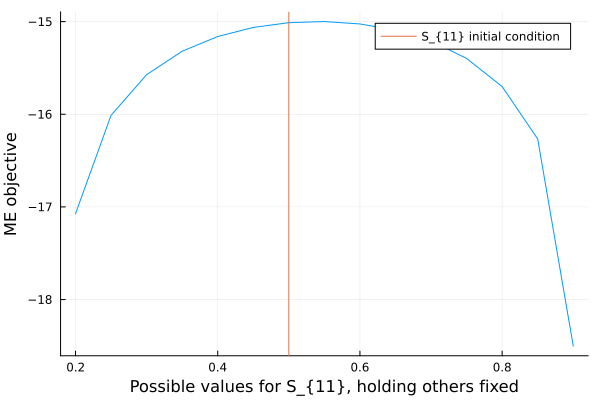

In [35]:
function perturb_first_coordinate(S_me, val, m)
    S_me_copy = copy(S_me)
    S_me_copy[1, 1] = val
    obj = group_block_objective(Σ, S_me_copy, m, :maxent)
    return obj
end

objs = Float64[]
for i in 0.2:0.05:0.9
    push!(objs, perturb_first_coordinate(me_ccd, i, m))
end

plot(0.2:0.05:0.9, objs, label=false, ylabel="ME objective",
    xlabel="Possible values for S_{11}, holding others fixed")
vline!([0.5], label="S_{11} initial condition")